# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [ ]:
# Instalación del paquete

# conda install pandas-datareader
# pip install pandas-datareader

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data = pd.read_csv("FB.csv")
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,78.580002,78.930000,77.699997,78.449997,78.449997,18177500
1,2015-01-05,77.980003,79.250000,76.860001,77.190002,77.190002,26452200
2,2015-01-06,77.230003,77.589996,75.360001,76.150002,76.150002,27399300
3,2015-01-07,76.760002,77.360001,75.820000,76.150002,76.150002,22045300
4,2015-01-08,76.739998,78.230003,76.080002,78.180000,78.180000,23961000
...,...,...,...,...,...,...,...
1001,2018-12-24,123.099998,129.740005,123.019997,124.059998,124.059998,22066000
1002,2018-12-26,126.000000,134.240005,125.889999,134.179993,134.179993,39723400
1003,2018-12-27,132.440002,134.990005,129.669998,134.520004,134.520004,31202500
1004,2018-12-28,135.339996,135.919998,132.199997,133.199997,133.199997,22627600


In [7]:
aapl = yf.download("AAPL", start = "2020-01-01", end = "2021-01-01")
aapl

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059433,135480400
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349136,146322800
2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925644,118387200
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582657,108872000
2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750229,132079200
...,...,...,...,...,...,...
2020-12-24,131.320007,133.460007,131.100006,131.970001,129.514465,54930100
2020-12-28,133.990005,137.339996,133.509995,136.690002,134.146637,124486200
2020-12-29,138.050003,138.789993,134.339996,134.869995,132.360519,121047300


In [17]:


aapl = yf.download("AAPL","2020-01-01","2020-12-31")[["Adj Close"]]
aapl

[*********************100%%**********************]  1 of 1 completed


,Adj Close
Date,
2020-01-02,73.059433
2020-01-03,72.349129
2020-01-06,72.925636
2020-01-07,72.582672
2020-01-08,73.750237
...,...
2020-12-23,128.523285
2020-12-24,129.514450
2020-12-28,134.146637


## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

In [20]:
R = aapl.pct_change()
R

,Adj Close
Date,
2020-01-02,NaN
2020-01-03,-0.009722
2020-01-06,0.007968
2020-01-07,-0.004703
2020-01-08,0.016086
...,...
2020-12-23,-0.006976
2020-12-24,0.007712
2020-12-28,0.035766


<Axes: ylabel='Frequency'>

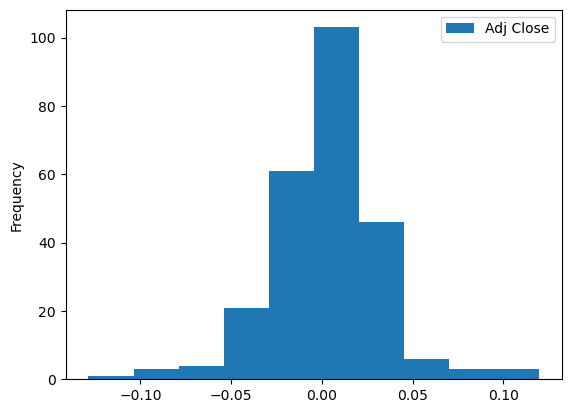

In [21]:
R.plot.hist()

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [22]:
R.describe()

,Adj Close
count,251.000000
mean,0.002769
std,0.029469
min,-0.128647
25%,-0.010608
50%,0.001749
75%,0.017181
max,0.119808


In [23]:
R.mean()

Adj Close    0.002769
dtype: float64

In [24]:
R.std()

Adj Close    0.029469
dtype: float64

(array([ 6., 15., 26., 45., 62., 45., 31., 13.,  6.,  2.]),
 array([-0.06754617, -0.05194086, -0.03633555, -0.02073023, -0.00512492,
         0.01048039,  0.0260857 ,  0.04169101,  0.05729633,  0.07290164,
         0.08850695]),
 <BarContainer object of 10 artists>)

<Figure size 640x480 with 0 Axes>

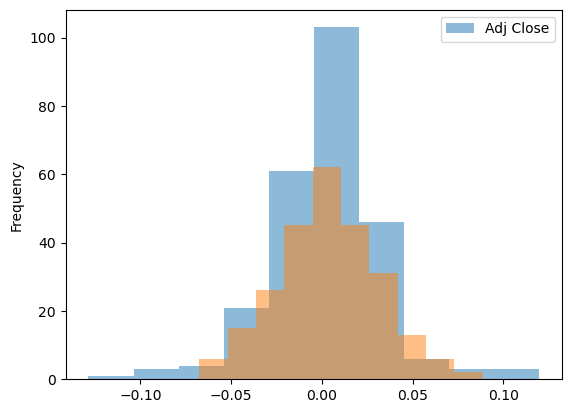

In [25]:
import numpy as np
sim_R = np.random.normal(R.mean(), R.std(), 251)
plt.figure()
R.plot.hist(alpha=0.5) #Alpha solo es para la transparencia de la gráfica

plt.hist(sim_R, alpha = 0.5)

Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos desde 2016, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2021 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [33]:
def simulacion(media, std, start, dias, N) : 
    sim_R = np.random.normal(media, std, size=(dias, N)) + 1
    fecha = pd.date_range(start, periods = dias)
    return pd.DataFrame(sim_R, index = fecha)

In [37]:
Sim_R = simulacion(R.mean(),R.std(),"2017-01-01", 10, 100)
Sim_R

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2017-01-01,1.017023,0.971891,1.022583,1.038114,0.971543,1.024963,1.007903,0.938200,1.018949,1.024076,...,1.016697,0.985558,0.981099,1.033688,1.020254,0.960548,0.990398,1.042316,0.975429,0.992477
2017-01-02,0.996974,1.002646,1.028532,1.041184,1.034511,1.056002,1.024562,0.981595,1.013044,0.969967,...,0.954041,0.992239,0.989520,0.946588,1.034964,1.045705,0.940586,1.004385,0.997796,0.947573
2017-01-03,1.038679,0.967234,1.025478,0.928537,1.003661,1.023481,1.007522,1.016969,1.024023,1.009253,...,0.975835,0.988504,0.964769,0.999013,1.022757,1.006387,1.010829,1.036680,1.020359,1.061243
2017-01-04,1.002667,1.019320,0.969274,1.026109,0.982786,1.002378,1.028295,1.004411,1.000427,0.945882,...,1.017597,0.953093,0.978423,0.989117,0.980174,1.032077,1.041293,1.035233,0.979572,0.984591
2017-01-05,1.006693,0.980458,0.973055,0.977628,0.983598,0.973031,1.011220,0.997838,1.025057,0.925910,...,1.011891,0.966045,0.968898,0.971951,1.010981,0.997083,1.033989,0.978652,1.034088,1.020911
2017-01-06,0.957766,1.015256,1.024506,0.971958,1.049163,0.970157,1.007069,0.989888,0.985678,1.027092,...,1.017764,0.981059,0.967938,1.030525,1.017858,0.980252,0.993010,1.006590,1.009138,0.995071
2017-01-07,0.993704,1.024241,1.002186,0.950358,0.968829,1.024002,0.982606,1.003129,1.013343,1.040954,...,0.990442,1.036363,0.962767,1.049310,0.996983,0.966693,1.022303,0.993885,0.965471,0.972000
2017-01-08,0.998537,0.996641,0.982486,0.959160,1.016154,1.042752,0.993552,1.009388,0.979537,1.037497,...,1.001478,0.952071,1.061592,0.947499,1.056033,1.006538,1.022579,1.031662,0.977677,0.995830
2017-01-09,0.981583,0.975620,1.058409,1.004080,1.022562,0.991365,1.033247,1.006097,0.991740,0.983456,...,1.052774,0.975838,1.080195,0.986245,1.003148,0.993434,1.011140,0.965758,0.964443,0.983344
2017-01-10,1.081683,0.963386,1.020560,0.965371,1.017758,1.017042,0.998924,0.983390,0.955740,1.003081,...,0.981670,1.046901,1.020857,0.972292,1.012784,1.030252,1.048472,1.036206,0.988215,0.994447


In [41]:
aapl.iloc[-1]

Adj Close    131.231903
Name: 2020-12-30 00:00:00, dtype: float64

In [39]:
Sim_R.cumprod().head(3)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2017-01-01,1.017023,0.971891,1.022583,1.038114,0.971543,1.024963,1.007903,0.938200,1.018949,1.024076,...,1.016697,0.985558,0.981099,1.033688,1.020254,0.960548,0.990398,1.042316,0.975429,0.992477
2017-01-02,1.013946,0.974462,1.051760,1.080868,1.005072,1.082363,1.032659,0.920933,1.032240,0.993320,...,0.969971,0.977909,0.970818,0.978476,1.055927,1.004449,0.931554,1.046887,0.973279,0.940444
2017-01-03,1.053165,0.942533,1.078556,1.003626,1.008752,1.107778,1.040427,0.936560,1.057038,1.002511,...,0.946532,0.966667,0.936615,0.977510,1.079957,1.010865,0.941642,1.085286,0.993095,0.998040


In [51]:
precios_simulados = Sim_R.cumprod()*26.9125
precios_simulados.tail()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2017-01-06,27.400786,25.737449,28.047588,26.335444,27.533270,28.210277,29.321654,25.006171,28.755000,24.269351,...,26.695986,23.499484,23.129572,26.063095,29.315265,27.442796,27.094589,29.786364,27.320538,26.865814
2017-01-07,27.228268,26.361353,28.108898,25.028106,26.675034,28.887369,28.811639,25.084418,29.138664,25.263271,...,26.440816,24.354002,22.268393,27.348268,29.226829,26.528751,27.698867,29.604219,26.377180,26.113583
2017-01-08,27.188442,26.272800,27.616594,24.005956,27.105943,30.122376,28.625853,25.319916,28.542411,26.210564,...,26.479892,23.186745,23.639944,25.912467,30.864486,26.702184,28.324280,30.541558,25.788372,26.004684
2017-01-09,26.687724,25.632258,29.229660,24.103900,27.717504,29.862279,29.577566,25.474290,28.306645,25.776928,...,27.877337,22.626505,25.535756,25.556048,30.961653,26.526871,28.639826,29.495740,24.871409,25.571548
2017-01-10,28.867667,24.693757,29.830617,23.269196,28.209725,30.371178,29.545728,25.051164,27.053790,25.856359,...,27.366337,23.687708,26.068349,24.847945,31.357457,27.329367,30.028058,30.563651,24.578304,25.429543


In [52]:
precios_simulados.mean(axis=1)

2017-01-01    26.975986
2017-01-02    26.918640
2017-01-03    26.948452
2017-01-04    26.965407
2017-01-05    26.992279
2017-01-06    27.230471
2017-01-07    27.193211
2017-01-08    27.277942
2017-01-09    27.261488
2017-01-10    27.401160
Freq: D, dtype: float64

## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2018.

Con los rendimientos, calculamos los precios de cierre...

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [56]:
sim_R = simulacion(R.mean(), R.std(), "2017-01-01", 1000, 100000)
(sim_R.cumprod()*26.912588 > 28).mean(axis=1)

2017-01-01    0.10208
2017-01-02    0.20064
2017-01-03    0.26049
2017-01-04    0.30151
2017-01-05    0.33660
               ...   
2019-09-23    0.99305
2019-09-24    0.99306
2019-09-25    0.99297
2019-09-26    0.99309
2019-09-27    0.99303
Freq: D, Length: 1000, dtype: float64

In [58]:
#Con microsoft

def getclose(names, start, end):
    return yf.download(names, start=start, end=end)[["Adj Close"]]

msft = getclose("MSFT", "2016-01-01","2016-12-31")
R_msft = msft.pct_change()
msft_mean = R_msft.mean()
msft_std = R_msft.std()
sim_R_msft = simulacion(msft_mean,msft_std,"2017-01-01",265,10000)
(sim_R_msft.cumprod()*56.632259 > 56.632259*1.05).mean(axis=1)

[*********************100%%**********************]  1 of 1 completed


2017-01-01    0.0001
2017-01-02    0.0087
2017-01-03    0.0252
2017-01-04    0.0485
2017-01-05    0.0704
               ...  
2017-09-18    0.6772
2017-09-19    0.6789
2017-09-20    0.6803
2017-09-21    0.6820
2017-09-22    0.6815
Freq: D, Length: 265, dtype: float64

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.